In [89]:
# dependencies
import pandas as pd
import matplotlib.pyplot as plt
import tweepy

# sentiment analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# twitter keys
from config import (consumer_key, consumer_secret, access_token, access_token_secret)

# tweepy api authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [97]:
df = pd.read_csv('whites_and_reds.csv')
df = df.drop(columns=['Unnamed: 0'])
df = df.dropna(axis=0, how='any')
df = df[['points', 'taster', 'twitter handle']]

In [62]:
# find tasters with over 1000 reviews
taster_counts = pd.DataFrame(df['taster'].value_counts())
taster_counts = taster_counts.reset_index()
taster_counts = taster_counts.rename(columns={'taster':'ratings', 'index':'taster'})
taster_counts_over_1000 = taster_counts.loc[taster_counts['ratings'] > 1000]
tasters = taster_counts_over_1000['taster'].tolist()
tasters.sort()

In [ ]:
# find tasters' corresponding twitter handles
handle_df = df.set_index('taster')
target_users = pd.DataFrame(handle_df.loc[tasters, 'twitter handle'])
target_users = target_users['twitter handle'].unique()
target_users

In [107]:
# find averages for tasters with over 1000 reviews
ave_ratings = []
for taster in tasters:
    test_df = df.loc[df['taster'] == taster]
    test_rating = test_df['points'].mean()#.round(3)
    results_list = {'taster': taster, 'average rating': test_rating}
    ave_ratings.append(results_list)
ave_ratings_df = pd.DataFrame(ave_ratings).round(3)
ave_ratings_df = ave_ratings_df[['taster', 'average rating']]
ave_ratings_df['twitter handle'] = target_users
ave_ratings_df

,taster,average rating,twitter handle
0,Anne Krebiehl MW,91.202,@AnneInVino
1,Jim Gordon,88.433,@gordone_cellars
2,Joe Czerwinski,88.155,@JoeCz
3,Kerin O’Keefe,88.879,@kerinokeefe
4,Matt Kettmann,90.237,@mattkettmann
5,Michael Schachner,86.518,@wineschach
6,Paul Gregutt,89.204,@paulgwine
7,Roger Voss,89.231,@vossroger
8,Sean P. Sullivan,87.915,@wawinereport
9,Virginie Boone,89.385,@vboone


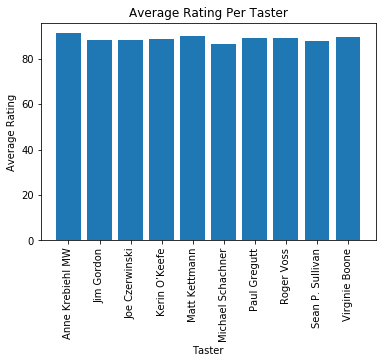

In [64]:
# bar chart for average points per taster
x_axis = np.arange(len(tasters))
plt.bar(ave_ratings_df['taster'], ave_ratings_df['average rating'])
plt.xticks(rotation = 'vertical')
plt.title('Average Rating Per Taster')
plt.xlabel('Taster')
plt.ylabel('Average Rating')
plt.show()

In [112]:
# sentiment analysis
overall_compound = []
target_users = ['@AnneInVino', '@gordone_cellars', '@JoeCz', '@kerinokeefe', '@mattkettmann', '@wineschach', 
                '@paulgwine', '@vossroger', '@wawinereport', '@vboone']

for user in target_users:
    compound_list = []
    
    for x in range(1):
        public_tweets = api.user_timeline(user, page = 1)

        for tweet in public_tweets:
            results = analyzer.polarity_scores(tweet['text'])
            compound_list.append(results['compound'])
            #results_list= {'user': user, 'compound': results['compound']}
            #all_tweets.append(results_list)
    
    compound_results = {'username': user, 'compound': np.mean(compound_list)}
    overall_compound.append(compound_results)

sentiment_df = pd.DataFrame(overall_compound).round(3)
sentiment_df['taster'] = tasters
sentiment_df['average rating'] = ave_ratings_df['average rating']
sentiment_df = sentiment_df[['taster', 'username', 'compound', 'average rating']]
sentiment_df

,taster,username,compound,average rating
0,Anne Krebiehl MW,@AnneInVino,0.350,91.202
1,Jim Gordon,@gordone_cellars,0.266,88.433
2,Joe Czerwinski,@JoeCz,0.070,88.155
3,Kerin O’Keefe,@kerinokeefe,0.223,88.879
4,Matt Kettmann,@mattkettmann,0.236,90.237
5,Michael Schachner,@wineschach,0.251,86.518
6,Paul Gregutt,@paulgwine,0.436,89.204
7,Roger Voss,@vossroger,0.272,89.231
8,Sean P. Sullivan,@wawinereport,0.333,87.915
9,Virginie Boone,@vboone,0.198,89.385


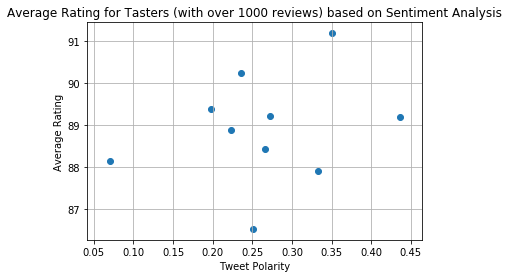

In [114]:
#compound vs. average points (scatter)
plt.scatter(sentiment_df['compound'], sentiment_df['average rating'])
plt.grid()
plt.title('Average Rating for Tasters (with over 1000 reviews) based on Sentiment Analysis')
plt.xlabel('Tweet Polarity')
plt.ylabel('Average Rating')
plt.show()